## **Taller 4 Modelos fundacionales**

In [ ]:
#!pip install -q timm  # Para Vision Transformers (ViT de HuggingFace vía timm)

In [ ]:
!pip install -q datasets

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import timm
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset



In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ruta_tar = '/content/drive/MyDrive/EAFIT/Semestre3/Visualizacion_de_datos/Talleres/tiny-imagenet-200/tiny-imagenet-200.tar'
!tar -xf "$ruta_tar"

#Tarea de pretexto, transformación

In [ ]:
# ✅ Transformación más liviana
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # ⚠️ Cambiado de 224 a 128 para acelerar
    transforms.ToTensor()
])

# ✅ Dataset con rotación como tarea de pretexto
class RotatedDataset(Dataset):
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]
        angle = random.choice([0, 90, 180, 270])
        img_rotada = TF.rotate(img, angle)
        if self.transform:
            img_rotada = self.transform(img_rotada)
        label = angle // 90  # 0: 0°, 1: 90°, 2: 180°, 3: 270°
        return img_rotada, label

#Cargar el dataset train desde la carpeta

In [ ]:
# 📁 Ruta del dataset ya descomprimido
data_dir = "/content/tiny-imagenet-200"

# ✅ Cargar todas las imágenes etiquetadas (para SSL ignoramos las etiquetas)
base_dataset = datasets.ImageFolder(root=f"{data_dir}/train")

# ✅ Submuestreo aleatorio: usar solo el 30% del dataset para acelerar entrenamiento
total = len(base_dataset)
subsample_ratio = 0.6  # Puedes ajustar entre 0.2 y 0.5 según tu tiempo
indices = np.random.choice(total, size=int(subsample_ratio * total), replace=False)
subset_dataset = Subset(base_dataset, indices)

# ✅ Aplicar la tarea de pretexto sobre el subset
ssl_dataset = RotatedDataset(subset_dataset, transform=transform)

# ✅ DataLoader optimizado
train_loader = DataLoader(
    ssl_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,              # Aumentado para mejor paralelismo
    pin_memory=True,            # Optimiza la transferencia a GPU
    persistent_workers=True     # Mantiene vivos los workers entre batches
)

print(f"🔍 Dataset reducido: {len(ssl_dataset)} imágenes cargadas para SSL")


🔍 Dataset reducido: 60000 imágenes cargadas para SSL


**Modelo 1: CNN sencilla**

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 128 → 64
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 64 → 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 32 → 16
            nn.Flatten()
        )
        self.classifier = nn.Linear(64 * 16 * 16, 4)  # 4 clases de rotación

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

**Modelo 2: ViT preentrenado con timm**

In [ ]:
import timm

class ViTRotation(nn.Module):
    def __init__(self):
        super(ViTRotation, self).__init__()
        self.encoder = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.encoder.head = nn.Identity()  # Eliminamos la capa final
        self.classifier = nn.Linear(self.encoder.num_features, 4)  # 4 clases de rotación

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)


#**Implementación del modelo**

In [ ]:
def train_model(model, dataloader, epochs=5):
    import torch
    import torch.optim as optim

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        avg_loss = total_loss / len(dataloader)
        print(f"✅ Epoch {epoch+1}: Loss = {avg_loss:.4f} | Accuracy = {acc:.4f}")


In [ ]:
#Entrenar CCN

cnn_model = SimpleCNN()
print("🔧 Entrenando CNN...")
train_model(cnn_model, train_loader, epochs=15)

🔧 Entrenando CNN...


Epoch 1/15: 100%|██████████| 938/938 [14:19<00:00,  1.09it/s]


✅ Epoch 1: Loss = 1.2898 | Accuracy = 0.4162


Epoch 2/15: 100%|██████████| 938/938 [14:23<00:00,  1.09it/s]


✅ Epoch 2: Loss = 1.2488 | Accuracy = 0.4487


Epoch 3/15: 100%|██████████| 938/938 [15:31<00:00,  1.01it/s]


✅ Epoch 3: Loss = 1.2312 | Accuracy = 0.4593


Epoch 4/15: 100%|██████████| 938/938 [14:28<00:00,  1.08it/s]


✅ Epoch 4: Loss = 1.2196 | Accuracy = 0.4717


Epoch 5/15: 100%|██████████| 938/938 [14:34<00:00,  1.07it/s]


✅ Epoch 5: Loss = 1.2102 | Accuracy = 0.4775


Epoch 6/15: 100%|██████████| 938/938 [14:35<00:00,  1.07it/s]


✅ Epoch 6: Loss = 1.2015 | Accuracy = 0.4831


Epoch 7/15: 100%|██████████| 938/938 [14:14<00:00,  1.10it/s]


✅ Epoch 7: Loss = 1.1940 | Accuracy = 0.4889


Epoch 8/15: 100%|██████████| 938/938 [14:53<00:00,  1.05it/s]


✅ Epoch 8: Loss = 1.1860 | Accuracy = 0.4934


Epoch 9/15: 100%|██████████| 938/938 [14:34<00:00,  1.07it/s]


✅ Epoch 9: Loss = 1.1765 | Accuracy = 0.4996


Epoch 10/15: 100%|██████████| 938/938 [14:33<00:00,  1.07it/s]


✅ Epoch 10: Loss = 1.1673 | Accuracy = 0.5058


Epoch 11/15: 100%|██████████| 938/938 [14:40<00:00,  1.07it/s]


✅ Epoch 11: Loss = 1.1609 | Accuracy = 0.5098


Epoch 12/15: 100%|██████████| 938/938 [14:32<00:00,  1.08it/s]


✅ Epoch 12: Loss = 1.1518 | Accuracy = 0.5125


Epoch 13/15: 100%|██████████| 938/938 [14:37<00:00,  1.07it/s]


✅ Epoch 13: Loss = 1.1446 | Accuracy = 0.5191


Epoch 14/15: 100%|██████████| 938/938 [14:28<00:00,  1.08it/s]


✅ Epoch 14: Loss = 1.1391 | Accuracy = 0.5209


Epoch 15/15: 100%|██████████| 938/938 [14:34<00:00,  1.07it/s]

✅ Epoch 15: Loss = 1.1337 | Accuracy = 0.5222


In [ ]:
#Entrenar VIT
#vit_model = ViTRotation()
#print("🔧 Entrenando ViT...")
#train_model(vit_model, train_loader, epochs=5)


# **Visualizar resultados de predicción**

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualizar_rotaciones(modelo, dataloader, clases=['0°', '90°', '180°', '270°'], num_ejemplos=6):
    modelo.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelo.to(device)

    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = modelo(images)
        pred = outputs.argmax(dim=1)

    plt.figure(figsize=(15, 5))
    for i in range(num_ejemplos):
        img = images[i].cpu().permute(1, 2, 0)
        real = clases[labels[i].item()]
        predicho = clases[pred[i].item()]
        color = "green" if real == predicho else "red"

        plt.subplot(1, num_ejemplos, i+1)
        plt.imshow(img)
        plt.title(f"Real: {real}\nPred: {predicho}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

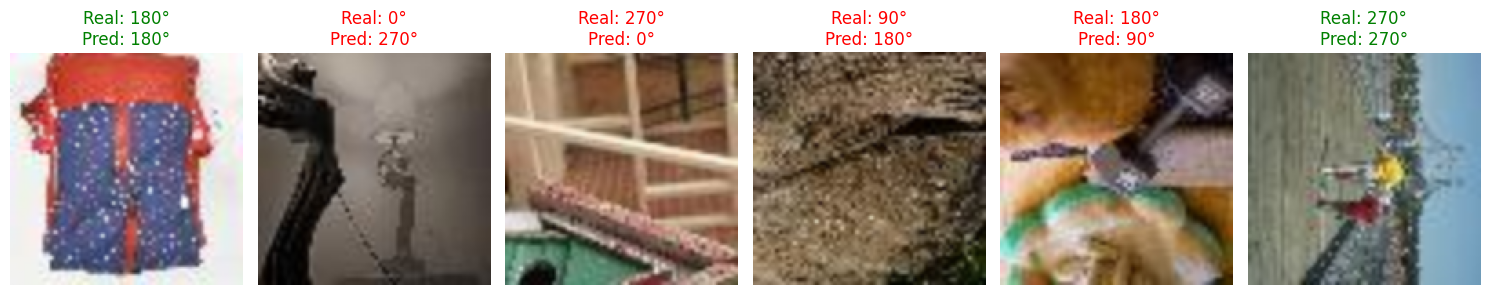

In [ ]:
#Rotaciones cnn_model sencilla
visualizar_rotaciones(cnn_model, train_loader)

#Experimentos realizados

| Modelo       | % Dataset usado | Épocas | Accuracy final |
| ------------ | --------------- | ------ | -------------- |
| CNN sencilla | 30%             | 5      | 46.05%         |
| CNN sencilla | 60%             | 15     | 52.22%         |
| CNN compleja | 30%             | 5      | 44.91%         |


# Conclusiones clave
- El modelo simple con más datos y más épocas superó al modelo complejo. La cantidad de datos y el entrenamiento prolongado tuvieron mayor impacto que la complejidad del modelo.

- Aunque la CNN compleja presentaba una arquitectura más profunda y expresiva, con mayor número de filtros y capas convolucionales, no superó en desempeño a la CNN sencilla cuando ambas fueron entrenadas con el mismo porcentaje de datos (30%). La CNN sencilla, más ligera y rápida de entrenar, alcanzó una accuracy final de 46.05%, superando ligeramente a la CNN compleja (44.91%). Esto sugiere que, en contextos con recursos limitados o pocos datos, un modelo más simple puede generalizar mejor y entrenarse más eficientemente.

- Más datos + más tiempo de entrenamiento = mejor representación auto-supervisada.

- Las visualizaciones muestran que el modelo predice bien clases como 0° o 180°, pero tiene dificultades con rotaciones más sutiles (90°/270°), especialmente en imágenes poco estructuradas.

- Limitaciones computacionales impidieron usar el 100% del dataset o probar modelos más grandes como ViT, al intentar realizar este ejercicio la capacidad computacional falló, aún cuando solamente se intentó trabajar con el 60 % y 30% de los datos.

